In [1]:
import random
import numpy as np
from numba import njit
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Exercises

For the exam prepare two of these exercises.

## Q1: The stock market

(This is about numba)

A Markov Chain is defined as a sequence of random variables where a parameter depends *only* on the preceding value. This is a crucial tool in statistics, widely used in science and beyond (economics for instance).

For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would be a Markov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)

where the numbers on the arrows indicate the probabily that the next day will be in a given state.

Your task is to simulate the stock market according to this rule. Start from a random state and simulate many many  iterations. If your code is right, the fraction of days in each state should converge. 

Implement a pure-python version and a numba version, and compare speeds. 


---

Very basic implementation just to see the bare code

In [2]:
states = ["bull", "bear", "stagnant"]

def evolve_market(init_state, n_iters):
    h = [init_state]
    for _ in range(int(n_iters)):
        rv = random.random()
        today = h[-1]
        if today == "bull":
            if rv < 0.1:
                if rv < 0.025:
                    h.append( "stagnant" )
                else:
                    h.append( "bear" )
            else:
                h.append( "bull" )
        elif today == "bear":
            if rv < 0.2:
                if rv < 0.15:
                    h.append( "bull" )
                else:
                    h.append( "stagnant" )
            else:
                h.append( "bear" )
        else:
            if rv < 0.5:
                if rv < 0.25:
                    h.append( "bear" )
                else:
                    h.append( "bull" )
            else:
                h.append( "stagnant" )
    return h

c_evolve_market = njit(evolve_market)

# run first time
ignore = c_evolve_market("bull", 1e5)

In [3]:
%%time

h = evolve_market("bull", 1e5)

res = dict((s, h.count(s)) for s in states)
res

CPU times: user 13.8 ms, sys: 247 µs, total: 14.1 ms
Wall time: 14 ms


{'bull': 62760, 'bear': 30912, 'stagnant': 6329}

In [4]:
%%time

h = c_evolve_market("bull", 1e5)

res = dict((s, h.count(s)) for s in states)
res

CPU times: user 16.2 ms, sys: 6.46 ms, total: 22.6 ms
Wall time: 22.4 ms


{'bull': 62506, 'bear': 31279, 'stagnant': 6216}

There is no visible improvement... This might be due to the fact that the code is really bad so it is best to first clean it up:
1. the states can be encoded into integers `0,1,2`, this is also convenient since they become indexes
2. we can exploit the cyclic properties of the graph

In [5]:
'''
It can be seen as a directed graph where the market states are the vertices and the directed edges give the transition probability
'''

states = [0, 1, 2]        # ["bull", "bear", "stagnant"]

'''
The probabilities can be arranged into lists: each probability list has: 
    · the prob. of staying in the same state (index 0)
    · the prob. of going to the state to the right (index 1) - cf. the `states` list
    · the prob. of going to the state to the left (index 2 - OMITTED)
'''
p_bull = [0.9, 0.075]   # no need for third prob , 0.025] thanks to normalization
p_bear = [0.8, 0.05]    # no need for third prob , 0.15] thanks to normalization
p_stag = [0.5, 0.25]    # no need for third prob , 0.25] thanks to normalization
edges = np.array([p_bull, p_bear, p_stag])

In [6]:
def evolve_market(init_state, n_iters):
    h = [init_state]
    for _ in range(int(n_iters)):
        rv = random.random()
        today = h[-1]
        probs = edges[today]
        
        if rv < (1 - probs[0]):
            if rv < probs[1]:
                h.append((today + 1)%3) # look at the right
            else:
                h.append((today + 2)%3) # look at the left
        else:
            h.append(today)
    return h

c_evolve_market = njit(evolve_market)

# run first time
ignore = c_evolve_market(0, 100)

In [7]:
%%time

h = evolve_market(0, 1e5)

res = dict((s, h.count(s)) for s in states)
res

CPU times: user 33.7 ms, sys: 207 µs, total: 33.9 ms
Wall time: 33.1 ms


{0: 62482, 1: 31181, 2: 6338}

In [8]:
%%time

h = c_evolve_market(0, 1e5)

res = dict((s, h.count(s)) for s in states)
res

CPU times: user 165 ms, sys: 7.77 ms, total: 173 ms
Wall time: 172 ms


{0: 63619, 1: 30148, 2: 6234}

The non-numba version is slower than before probably for the `%` operation, but here we see a speedup with the precompiled version!

---

Now we can see the convergence of the counts of each state:

In [9]:
df = pd.DataFrame(columns=["Iter", "Bull", "Bear", "Stagnant"])

random.seed(42)

iterations = np.logspace(1, 6, 100, dtype=int) # from 10^1 to 10^6
for iter in tqdm(iterations):
    h = c_evolve_market(random.choice([0,1,2]), iter) # not efficient
    res = dict((s, h.count(s)) for s in states) # get the counts
    df.loc[len(df.index)] = [iter]+list(res.values()) # put the values into the dataframe saving also the number of iterations

100%|██████████| 100/100 [00:00<00:00, 237.70it/s]


In [10]:
df.Bull /= df.Iter
df.Bear /= df.Iter
df.Stagnant /= df.Iter

it should be done on a single run but this way I don't have to rewrite the `evolve_market` function

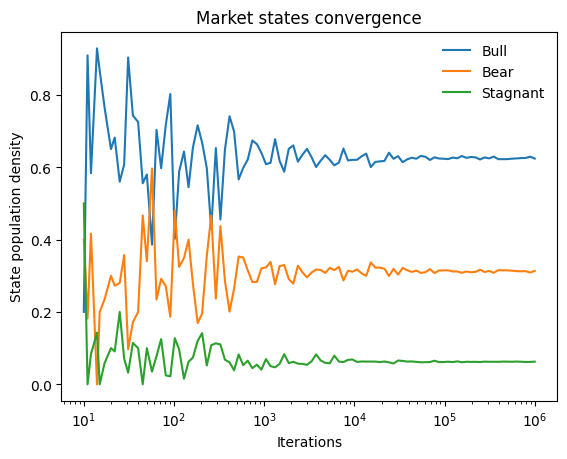

In [11]:
plt.title("Market states convergence")

plt.semilogx(df.Iter, df.Bull, label="Bull")
plt.semilogx(df.Iter, df.Bear, label="Bear")
plt.semilogx(df.Iter, df.Stagnant, label="Stagnant")

plt.xlabel("Iterations")
plt.ylabel("State population density")

plt.legend(loc='best', frameon=False)
plt.show()

In [12]:
# convergence values
df.tail(1)

,Iter,Bull,Bear,Stagnant
99,1000000,0.623938,0.313445,0.062618


## Q3: Scaling

(This is about multiprocessing)

The ["scaling"](https://hpc-wiki.info/hpc/Scaling) of a code refers to its performance of as a function of the number of cores adopted. 

- Define a computationally intensive task (something like an operation on two giant arrays with >1e7 numbers or, even better!, pick somethinbg from your research). 
- Make sure it's embarassingly parallel. 
- Implement a parallelization strategy using multiprocessing. 
- Plot the time the code takes as a function of the number of cores.
- Figure out the number of cores in your CPU and make sure the plot extends both below and above this number.
- Interpret the resulting features. 
- A perfect scaling result in straight line (linear dependency). How perfect is your scaling?

### Important
Numpy has some inner, semi-automatic parallelization functionalities. Some, but not all, numpy functions detect the number of CPUs in your machine and make good use of them. That's great for most applications, but when performing a scaling study you want to control the parallelization yourself and disable what's done by numpy's. The following forces numpy to use a single core.  

In [13]:
import numpy as np
np.__config__.show()
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /usr/local/include
    lib directory: /usr/local/lib
    name: openblas64
    openblas configuration: USE_64BITINT=1 DYNAMIC_ARCH=1 DYNAMIC_OLDER= NO_CBLAS=
      NO_LAPACK= NO_LAPACKE= NO_AFFINITY=1 USE_OPENMP= HASWELL MAX_THREADS=2
    pc file directory: /usr/local/lib/pkgconfig
    version: 0.3.23.dev
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep139755841617168
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.2
Compilers:
  c:
    commands: cc
    linker: ld.bfd
    name: gcc
    version: 10.2.1
  c++:
    commands: c++
    linker: ld.bfd
    name: gcc
    version: 10.2.1
  cython:
    commands: cython
    linker: cython
    name: cython
    version: 3.0.5
Machine Information:
  build:
    cpu: x86_64
    endian: little
    family: x86_64
    system: linux
  host:
    

In [14]:
import multiprocessing

In [15]:
multiprocessing.cpu_count()

16

In [16]:
def fun(a,b,c):
    time.sleep(1e-9)
    return int(np.sqrt(a**b**c))

In [17]:
N=int(1e5)
a=np.linspace(1, 10, N, dtype=np.float64)
b=np.linspace(1, 5, N)
c=np.linspace(1, 2, N)

In [18]:
%%time 

res1 = list(tqdm(map(fun, a,b,c), total=N))

100%|██████████| 100000/100000 [00:06<00:00, 15736.01it/s]

CPU times: user 706 ms, sys: 311 ms, total: 1.02 s
Wall time: 6.36 s


In [19]:
CPUS = 5
# Now, this is much faster!
parmap = multiprocessing.Pool(CPUS).starmap

In [20]:
%%time 

res2 = list(tqdm(parmap(fun, zip(a,b,c)), total=N))

100%|██████████| 100000/100000 [00:00<00:00, 965826.41it/s]

CPU times: user 567 ms, sys: 92.4 ms, total: 660 ms
Wall time: 1.56 s


In [21]:
res1 == res2

True

In [22]:
history = []
cpu_list = np.arange(1,17)
for cpu in cpu_list:
    parmap = multiprocessing.Pool(cpu).starmap
    t1 = time.time()
    res2 = list(parmap(fun, zip(a,b,c)))
    t2 = time.time()
    history.append(t2-t1)

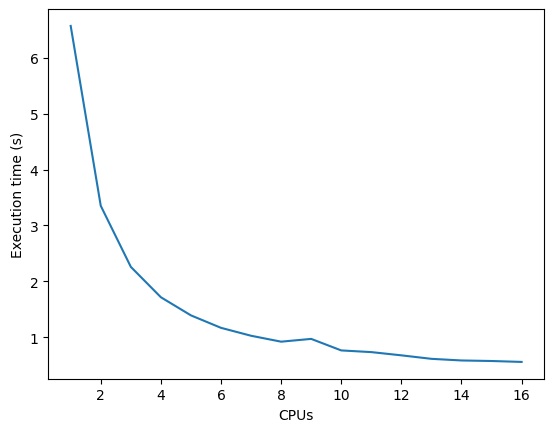

In [23]:
plt.plot(cpu_list, history)
plt.ylabel("Execution time (s)")
plt.xlabel("CPUs")
plt.show()